In [61]:
import lyricsgenius
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import spotipy
import string

from adjustText import adjust_text
from nltk.corpus import stopwords
from spotipy.oauth2 import SpotifyClientCredentials

# API setup
# NOTE: this requires setup of Spotify and Genius developer accounts for credentials
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
genius = lyricsgenius.Genius(genius_secret)

# Set up stop words and punctuation for removal
filterWords = stopwords.words("english")
translator = str.maketrans('', '', string.punctuation)

In [62]:
# Returns dataframe of lyrics for tracks in song_list via Genius API
def get_lyrics_from_song_names(artist_name, song_list):
    artist = genius.search_artist(artist_name, max_songs=0)
    lyrics = []
    song_names = []
    
    # Parse songs
    for song_title in song_list:
        song = genius.search_song(song_title, artist.name, take_first_result=True, remove_section_headers=True)
        if song is not None:
            song_lyrics = ' '.join([word for word in song.lyrics.split() if word.lower() not in filterWords])
            lyrics.append(song_lyrics.translate(translator))
            song_names.append(song_title)

    return pd.DataFrame(data=lyrics, index=song_names, columns = ['lyrics'])

In [63]:
# Returns dataframe of track information for tracks from each album in album_list via Spotify API
def get_tracks_from_albums(album_list):
    features_list = []
    track_names = []
    
    # Parse albums
    for album in album_list:
        results = spotify.search(q=album, type='album')
        uri = results['albums']['items'][0]['id']
        album_tracks = spotify.album_tracks(uri)
        
        # Parse tracks
        for item in album_tracks['items']:
            # Handle bonus tracks
            if 'Bonus' not in item['name']:
                audio_features = spotify.audio_features(item['id'])[0]
                audio_features['album'] = album
                features_list.append(audio_features)
                name = item['name'].replace('’', '\'')
                # Replace for asterisk in F*ck Your Ethnicity
                name = name.replace('*', 'u')
                # Handle extended versions
                if 'Extended' in name:
                    name = name.split('Extended')[0]
                if 'FEAT.' in name:
                    name = name.split('FEAT.')[0]
                track_names.append(name)
     
    return pd.DataFrame(data=features_list, index=track_names)

In [64]:
# Returns dictionary mapping each word to a list of corresponding sentiments
def read_lexicon(filename):
    word_sentiments = {}
    
    # Parse lexicon file
    with open(filename, 'r') as f:
        for line in f:
            # Ignore blank lines
            if line.strip():
                word, sentiment, value = line.split()
                if value == '1':
                    # Add sentiment to dictionary
                    cur_list = word_sentiments.get(word, [])
                    cur_list.append(sentiment)
                    word_sentiments[word] = cur_list
    
    return word_sentiments  

In [65]:
# Returns dataframe of sentiment percentages for each track in an input dataframe
def get_sentiment_percentages(track_df, sentiment):
    sentiment_pcts = []
    
    # Parse tracks
    for track_name in track_df.index.values:
        num_sentiment_words = 0
        all_words = track_df.loc[track_name]['lyrics'].split()
        
        # Parse words in lyrics
        for word in all_words:
            if sentiment in word_sentiments_dict.get(word, []):
                num_sentiment_words += 1
                
        sentiment_pcts.append(num_sentiment_words/len(all_words))

    return pd.DataFrame(data=sentiment_pcts, index=track_df.index.values, columns = [sentiment + '_pct'])

In [66]:
# Initialize sentiment dictionary and track dataframe
word_sentiments_dict = read_lexicon('nrc-emotion-lexicon.txt')
spotify_df = get_tracks_from_albums(['Section 80', 'good kid, m.A.A.d city', 'To Pimp a Butterfly', 'DAMN'])
genius_df = get_lyrics_from_song_names('Kendrick Lamar', spotify_df.index.values)
track_df = spotify_df.join(genius_df).dropna(subset=['lyrics'])

track_df

Searching for songs by Kendrick Lamar...

Done.
Searching for "Fuck Your Ethnicity" by Kendrick Lamar...
Done.
Searching for "Hol' Up" by Kendrick Lamar...
Done.
Searching for "A.D.H.D" by Kendrick Lamar...
Done.
Searching for "No Make-Up (Her Vice)" by Kendrick Lamar...
Done.
Searching for "Tammy's Song (Her Evils)" by Kendrick Lamar...
Done.
Searching for "Chapter Six" by Kendrick Lamar...
Done.
Searching for "Ronald Reagan Era" by Kendrick Lamar...
Done.
Searching for "Poe Mans Dreams (His Vice)" by Kendrick Lamar...
Done.
Searching for "The Spiteful Chant" by Kendrick Lamar...
Done.
Searching for "Chapter Ten" by Kendrick Lamar...
Done.
Searching for "Keisha's Song (Her Pain)" by Kendrick Lamar...
Done.
Searching for "Rigamortus" by Kendrick Lamar...
Done.
Searching for "Kush & Corinthians" by Kendrick Lamar...
Done.
Searching for "Blow My High (Members Only)" by Kendrick Lamar...
Done.
Searching for "Ab-Souls Outro" by Kendrick Lamar...
Done.
Searching for "HiiiPower" by Kendrick 

,acousticness,album,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,lyrics
Fuck Your Ethnicity,0.392000,Section 80,https://api.spotify.com/v1/audio-analysis/5v50...,0.601,224672,0.883,5v501hmUMvbHPKa7qm0MGD,0.000019,0,0.3970,-6.944,1,0.3280,150.967,4,https://api.spotify.com/v1/tracks/5v501hmUMvbH...,audio_features,spotify:track:5v501hmUMvbHPKa7qm0MGD,0.5200,Gather around Im glad everybody came tonight s...
Hol' Up,0.781000,Section 80,https://api.spotify.com/v1/audio-analysis/5DO1...,0.607,173158,0.869,5DO1SazQppcsKQ1c1JpyQz,0.000000,5,0.1370,-5.271,1,0.3450,155.983,4,https://api.spotify.com/v1/tracks/5DO1SazQppcs...,audio_features,spotify:track:5DO1SazQppcsKQ1c1JpyQz,0.5770,wrote record thirtythousand feet air Stewardes...
A.D.H.D,0.330000,Section 80,https://api.spotify.com/v1/audio-analysis/2MYl...,0.609,215509,0.799,2MYl0er3UZ1RlKwRb5LODh,0.000000,9,0.1080,-6.883,1,0.2400,157.740,4,https://api.spotify.com/v1/tracks/2MYl0er3UZ1R...,audio_features,spotify:track:2MYl0er3UZ1RlKwRb5LODh,0.5820,Uhuh fuck fuck that Eight doobies face fuck Tw...
No Make-Up (Her Vice),0.541000,Section 80,https://api.spotify.com/v1/audio-analysis/7yQD...,0.535,235921,0.696,7yQDLdub1VuUUwbpteUX7w,0.005210,5,0.6300,-7.181,0,0.0901,91.002,4,https://api.spotify.com/v1/tracks/7yQDLdub1VuU...,audio_features,spotify:track:7yQDLdub1VuUUwbpteUX7w,0.2130,love way put eyes roses face light sky lips co...
Tammy's Song (Her Evils),0.924000,Section 80,https://api.spotify.com/v1/audio-analysis/3RPK...,0.477,161671,0.835,3RPK9VQuTsiTySY48ldeqx,0.000508,9,0.1290,-5.942,0,0.4380,97.317,3,https://api.spotify.com/v1/tracks/3RPK9VQuTsiT...,audio_features,spotify:track:3RPK9VQuTsiTySY48ldeqx,0.5200,judge know girl real good girl lowkey Looking ...
Chapter Six,0.533000,Section 80,https://api.spotify.com/v1/audio-analysis/3s3Z...,0.510,161138,0.537,3s3ZBjw8kKX5HXymkRIDVy,0.000000,4,0.1850,-11.297,0,0.0823,67.900,4,https://api.spotify.com/v1/tracks/3s3ZBjw8kKX5...,audio_features,spotify:track:3s3ZBjw8kKX5HXymkRIDVy,0.6700,Ridin boys girls were high want good time Youn...
Ronald Reagan Era,0.015200,Section 80,https://api.spotify.com/v1/audio-analysis/3gl1...,0.424,216900,0.828,3gl1RenSXn1biKijZ1qvky,0.000000,1,0.3890,-4.991,0,0.3350,167.469,4,https://api.spotify.com/v1/tracks/3gl1RenSXn1b...,audio_features,spotify:track:3gl1RenSXn1biKijZ1qvky,0.3000,Were far good good far 90 miles per hour Compt...
Poe Mans Dreams (His Vice),0.619000,Section 80,https://api.spotify.com/v1/audio-analysis/2NxI...,0.736,261874,0.892,2NxIp9jbmsnaIiAExWOEo0,0.000001,1,0.1110,-5.217,1,0.2800,88.124,4,https://api.spotify.com/v1/tracks/2NxIp9jbmsna...,audio_features,spotify:track:2NxIp9jbmsnaIiAExWOEo0,0.5970,Smoke good eat good live good Smoke good eat g...
The Spiteful Chant,0.050600,Section 80,https://api.spotify.com/v1/audio-analysis/12bC...,0.596,320957,0.783,12bCgkFnyyTI8B1OmmRhbx,0.000000,0,0.1810,-4.356,0,0.0313,127.018,4,https://api.spotify.com/v1/tracks/12bCgkFnyyTI...,audio_features,spotify:track:12bCgkFnyyTI8B1OmmRhbx,0.3340,know lot people smile face talk behind back ev...
Chapter Ten,0.035500,Section 80,https://api.spotify.com/v1/audio-analysis/2C1C...,0.515,75535,0.738,2C1C4QjjMmru4mYrPSQzWs,0.000373,11,0.2870,-6.391,0,0.2150,135.772,4,https://api.spotify.com/v1/tracks/2C1C4QjjMmru...,audio_features,spotify:track:2C1C4QjjMmru4mYrPSQzWs,0.5410,time learn time learn time learn Babies 80s kn...


In [67]:
# Generate sentiment percentages based on NRC Lexicon sentiments
sentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for sentiment in sentiments:
    sentiment_df = get_sentiment_percentages(track_df, sentiment)
    track_df = track_df.join(sentiment_df)

track_df

,acousticness,album,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,...,anger_pct,anticipation_pct,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct
Fuck Your Ethnicity,0.392000,Section 80,https://api.spotify.com/v1/audio-analysis/5v50...,0.601,224672,0.883,5v501hmUMvbHPKa7qm0MGD,0.000019,0,0.3970,...,0.053292,0.021944,0.050157,0.025078,0.015674,0.075235,0.037618,0.012539,0.006270,0.018809
Hol' Up,0.781000,Section 80,https://api.spotify.com/v1/audio-analysis/5DO1...,0.607,173158,0.869,5DO1SazQppcsKQ1c1JpyQz,0.000000,5,0.1370,...,0.081633,0.010204,0.064626,0.051020,0.010204,0.102041,0.044218,0.034014,0.023810,0.020408
A.D.H.D,0.330000,Section 80,https://api.spotify.com/v1/audio-analysis/2MYl...,0.609,215509,0.799,2MYl0er3UZ1RlKwRb5LODh,0.000000,9,0.1080,...,0.048780,0.012195,0.042683,0.027439,0.009146,0.088415,0.033537,0.027439,0.006098,0.024390
No Make-Up (Her Vice),0.541000,Section 80,https://api.spotify.com/v1/audio-analysis/7yQD...,0.535,235921,0.696,7yQDLdub1VuUUwbpteUX7w,0.005210,5,0.6300,...,0.014286,0.060714,0.007143,0.003571,0.064286,0.021429,0.092857,0.007143,0.007143,0.021429
Tammy's Song (Her Evils),0.924000,Section 80,https://api.spotify.com/v1/audio-analysis/3RPK...,0.477,161671,0.835,3RPK9VQuTsiTySY48ldeqx,0.000508,9,0.1290,...,0.044355,0.016129,0.032258,0.024194,0.024194,0.096774,0.040323,0.020161,0.012097,0.040323
Chapter Six,0.533000,Section 80,https://api.spotify.com/v1/audio-analysis/3s3Z...,0.510,161138,0.537,3s3ZBjw8kKX5HXymkRIDVy,0.000000,4,0.1850,...,0.034965,0.069930,0.000000,0.034965,0.041958,0.076923,0.062937,0.006993,0.062937,0.041958
Ronald Reagan Era,0.015200,Section 80,https://api.spotify.com/v1/audio-analysis/3gl1...,0.424,216900,0.828,3gl1RenSXn1biKijZ1qvky,0.000000,1,0.3890,...,0.081522,0.032609,0.048913,0.038043,0.021739,0.089674,0.046196,0.010870,0.008152,0.027174
Poe Mans Dreams (His Vice),0.619000,Section 80,https://api.spotify.com/v1/audio-analysis/2NxI...,0.736,261874,0.892,2NxIp9jbmsnaIiAExWOEo0,0.000001,1,0.1110,...,0.031320,0.125280,0.008949,0.017897,0.118568,0.055928,0.190157,0.020134,0.102908,0.138702
The Spiteful Chant,0.050600,Section 80,https://api.spotify.com/v1/audio-analysis/12bC...,0.596,320957,0.783,12bCgkFnyyTI8B1OmmRhbx,0.000000,0,0.1810,...,0.039823,0.013274,0.044248,0.030973,0.015487,0.090708,0.048673,0.024336,0.015487,0.024336
Chapter Ten,0.035500,Section 80,https://api.spotify.com/v1/audio-analysis/2C1C...,0.515,75535,0.738,2C1C4QjjMmru4mYrPSQzWs,0.000373,11,0.2870,...,0.056604,0.056604,0.018868,0.075472,0.000000,0.094340,0.113208,0.056604,0.000000,0.037736


In [68]:
# Calculate lyrical density and gloom index of tracks
track_df['lyrical_density'] = track_df.apply(lambda row: len(row.lyrics.split()) / row.duration_ms * 1000, axis=1)
track_df['gloom_index'] = track_df.apply(lambda row: 1 - (row.valence) + row.sadness_pct * (row.lyrical_density+1), axis=1)

track_df

,acousticness,album,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,...,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,lyrical_density,gloom_index
Fuck Your Ethnicity,0.392000,Section 80,https://api.spotify.com/v1/audio-analysis/5v50...,0.601,224672,0.883,5v501hmUMvbHPKa7qm0MGD,0.000019,0,0.3970,...,0.050157,0.025078,0.015674,0.075235,0.037618,0.012539,0.006270,0.018809,1.419848,0.510343
Hol' Up,0.781000,Section 80,https://api.spotify.com/v1/audio-analysis/5DO1...,0.607,173158,0.869,5DO1SazQppcsKQ1c1JpyQz,0.000000,5,0.1370,...,0.064626,0.051020,0.010204,0.102041,0.044218,0.034014,0.023810,0.020408,1.697871,0.514764
A.D.H.D,0.330000,Section 80,https://api.spotify.com/v1/audio-analysis/2MYl...,0.609,215509,0.799,2MYl0er3UZ1RlKwRb5LODh,0.000000,9,0.1080,...,0.042683,0.027439,0.009146,0.088415,0.033537,0.027439,0.006098,0.024390,1.521978,0.487201
No Make-Up (Her Vice),0.541000,Section 80,https://api.spotify.com/v1/audio-analysis/7yQD...,0.535,235921,0.696,7yQDLdub1VuUUwbpteUX7w,0.005210,5,0.6300,...,0.007143,0.003571,0.064286,0.021429,0.092857,0.007143,0.007143,0.021429,1.186838,0.802620
Tammy's Song (Her Evils),0.924000,Section 80,https://api.spotify.com/v1/audio-analysis/3RPK...,0.477,161671,0.835,3RPK9VQuTsiTySY48ldeqx,0.000508,9,0.1290,...,0.032258,0.024194,0.024194,0.096774,0.040323,0.020161,0.012097,0.040323,1.533980,0.531088
Chapter Six,0.533000,Section 80,https://api.spotify.com/v1/audio-analysis/3s3Z...,0.510,161138,0.537,3s3ZBjw8kKX5HXymkRIDVy,0.000000,4,0.1850,...,0.000000,0.034965,0.041958,0.076923,0.062937,0.006993,0.062937,0.041958,0.887438,0.343199
Ronald Reagan Era,0.015200,Section 80,https://api.spotify.com/v1/audio-analysis/3gl1...,0.424,216900,0.828,3gl1RenSXn1biKijZ1qvky,0.000000,1,0.3890,...,0.048913,0.038043,0.021739,0.089674,0.046196,0.010870,0.008152,0.027174,1.696634,0.729311
Poe Mans Dreams (His Vice),0.619000,Section 80,https://api.spotify.com/v1/audio-analysis/2NxI...,0.736,261874,0.892,2NxIp9jbmsnaIiAExWOEo0,0.000001,1,0.1110,...,0.008949,0.017897,0.118568,0.055928,0.190157,0.020134,0.102908,0.138702,1.706928,0.457502
The Spiteful Chant,0.050600,Section 80,https://api.spotify.com/v1/audio-analysis/12bC...,0.596,320957,0.783,12bCgkFnyyTI8B1OmmRhbx,0.000000,0,0.1810,...,0.044248,0.030973,0.015487,0.090708,0.048673,0.024336,0.015487,0.024336,1.408288,0.724609
Chapter Ten,0.035500,Section 80,https://api.spotify.com/v1/audio-analysis/2C1C...,0.515,75535,0.738,2C1C4QjjMmru4mYrPSQzWs,0.000373,11,0.2870,...,0.018868,0.075472,0.000000,0.094340,0.113208,0.056604,0.000000,0.037736,0.701661,0.555320


In [69]:
# Rescale track_df such that gloom indices are in range [0, 100]
rescale_df = track_df
max_gloom_value = track_df['gloom_index'].max()
min_gloom_value = track_df['gloom_index'].min()
rescale_df['gloom_index'] = (track_df['gloom_index'] - min_gloom_value) / (max_gloom_value - min_gloom_value) * 100

rescale_df['gloom_index'].sort_values(ascending=False)

Bitch, Don't Kill My Vibe                   100.000000
The Blacker The Berry                        86.820132
Swimming Pools (Drank) -                     77.189344
Real                                         74.480850
Keisha's Song (Her Pain)                     71.798503
m.A.A.d city                                 70.346481
Kush & Corinthians                           70.247796
Compton                                      69.002034
GOD.                                         66.223048
XXX.                                         64.569537
No Make-Up (Her Vice)                        63.919521
HUMBLE.                                      63.247609
Sing About Me, I'm Dying Of Thirst           63.076926
King Kunta                                   61.031225
For Sale? - Interlude                        59.036441
How Much A Dollar Cost                       57.575142
Sherane a.k.a Master Splinter's Daughter     57.307727
Ronald Reagan Era                            56.137594
Complexion

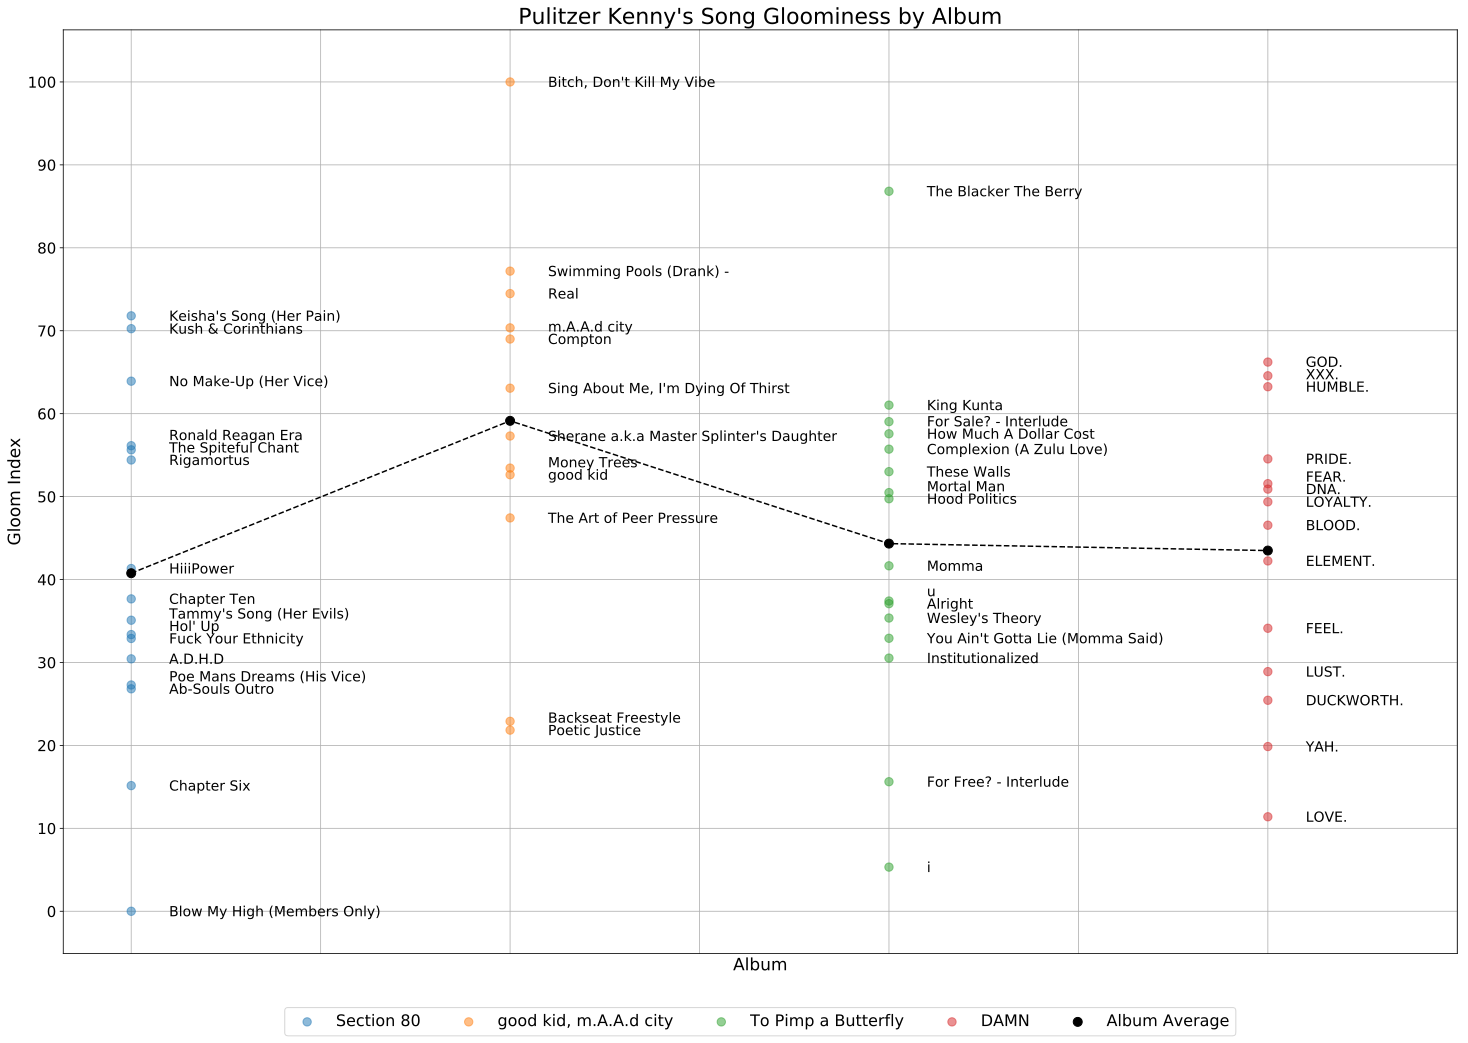

In [71]:
# Data plot

album_list = ['Section 80', 'good kid, m.A.A.d city', 'To Pimp a Butterfly', 'DAMN']
album_positions = []
album_means = []

scatter_plots = []
fig, ax = plt.subplots(figsize=(10,5))

# Create scatter for each album
for idx, album in enumerate(album_list):
    # Calculate coordinates and plot
    y = rescale_df['gloom_index'][rescale_df.album == album].sort_values()
    x = (idx + 1) * np.ones((1, len(y)))
    scatter = ax.scatter(x, y, alpha=0.5, s=70)
    scatter_plots.append(scatter)
    
    # Store x-coordinate and mean gloom index of each album
    album_positions.append(idx + 1)
    album_means.append(y.mean())
    
    # Modify positions of labels to prevent overlapping
    modified_positions = []
    overlap_dist = 1.5
    for pos, val in enumerate(y):
        # Calculate modified position
        if pos != 0 and val - modified_positions[pos - 1] < overlap_dist:
            modified_positions.append((overlap_dist - (val - modified_positions[pos - 1])) + val)
            modified_positions[pos - 1] -= (overlap_dist - 1)
        else:
            modified_positions.append(val)
        ax.annotate(y.index[pos], (idx+1, y[pos]), xytext=(idx+1.1, modified_positions[pos]-0.6), size=14)
        
# Plot album averages
scatter_plots.append(ax.scatter(album_positions, album_means, c='black', s=80))
ax.plot(album_positions, album_means, c='black', linestyle='--')

# Plot styling
ax.set_axisbelow(True)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
ax.set_xticks(np.arange(1, len(album_list) + 1, 0.5))
ax.tick_params(
    axis='y', 
    which='both',
    labelsize='15'
)
ax.set_yticks(np.arange(0, 110, 10))
ax.legend(scatter_plots,
           album_list + ['Album Average'],
           scatterpoints=1,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=6,
           fontsize=16
)
ax.set_title('Pulitzer Kenny\'s Song Gloominess by Album', fontsize=22)
ax.set_xlabel('Album', fontsize=17)
ax.set_ylabel('Gloom Index', fontsize=17)
ax.grid()
fig.set_size_inches(25, 17)

plt.savefig("result.png")
plt.show()